In [1]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [2]:
# load autoreload extension
%load_ext autoreload
%autoreload 2
# %cd '/lhome/ific/a/aamerio/github/diffusion'
%pwd

'/lhome/ific/a/aamerio/github/cfm-jax'

In [3]:
import sys
sys.path.append('./src')

In [4]:
from sbi_utils import Transformer
from sbi_utils.embedding import GaussianFourierEmbedding, SinusoidalEmbedding

from sbi.analysis import pairplot

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import ContinuousFMLoss

In [5]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array

from einops import rearrange, repeat
from flax import nnx
from tqdm.auto import tqdm
import os
jax.devices() # Should be cuda
_ = os.system("nvidia-smi  --query-gpu=name --format=csv,noheader") # Should show GPU info

Tesla V100-PCIE-32GB


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd

from functools import partial
from typing import Tuple, List, Optional

import optax # Gradient-based optimization in JAX
import numpy as np

In [7]:
# Set random key
key = jax.random.PRNGKey(0)

### 1) Setting up a toy problem

This is a simple toy problem to test the functionality of the `Simformer` method.
$$ \theta \sim \mathcal{N}(\theta; 0, 3^2) \qquad \qquad  x_1 \sim \mathcal{N}(x_1; 2\cdot\sin(\theta), 0.5^2)  \qquad \qquad   x_2 \sim \mathcal{N}(x_2;0.1\cdot \theta^2,  (0.5\cdot |x_1|)^2)$$

Here we have 3 nonlinear related Gaussian variables. The associated joint distirbution is visualized below.

In [8]:
def generate_data(key: PRNGKey, n:int):
    key1, key2, key3 = jrandom.split(key,3)
    theta1 = jrandom.normal(key1, (n, 1))  * 3 # Some prior on a parameter
    x1 = 2*jnp.sin(theta1) + jrandom.normal(key2, (n, 1)) * 0.5 # Some data generated from the parameter 
    x2 = 0.1*theta1**2 + 0.5*jnp.abs(x1)*jrandom.normal(key3, (n, 1)) # Some data generated from the parameter
    return jnp.concatenate([theta1,x1, x2], axis=1).reshape(n, -1)

def log_potential(theta1: Array, x1: Array, x2: Array, sigma_x1:float=0.5, sigma_x2:float=0.5, mean_loc:float=0.0, mean_scale:float=3.0 ):
    log_prob_theta = jax.scipy.stats.norm.logpdf(theta1, mean_loc, mean_scale)
    if x1 is not None:
        log_prob_x1 = jax.scipy.stats.norm.logpdf(x1, 2*jnp.sin(theta1), sigma_x1)
    else:
        log_prob_x1 = 0
    if x2 is not None:
        log_prob_x2 = jax.scipy.stats.norm.logpdf(x2, 0.1*theta1**2,  sigma_x2*jnp.abs(x1))
    else:
        log_prob_x2 = 0
    
    return log_prob_theta + log_prob_x1 + log_prob_x2
    

data = generate_data(jrandom.PRNGKey(1), 10000)  # Shape: (n, nodes, dim) here dim = 1
nodes_max = data.shape[1]
node_ids = jnp.arange(nodes_max)

In [9]:
data.shape

(10000, 3)

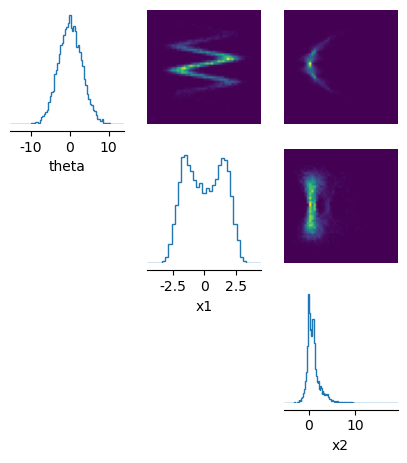

In [10]:
# _ = pairplot(np.array(data[...,0]), labels=["theta", "x1", "x2"], figsize=(5,5))
_ = pairplot(np.array(data), labels=["theta", "x1", "x2"], figsize=(5,5))

### 2) Setting up the diffusion process

We will use the VESDE i.e. the variance exploding stochastic differential equation. 

In [11]:
path = AffineProbPath(scheduler=CondOTScheduler())

### 3) Building the Simformer

This can be divided into two parts, each offering various choices:

* **Tokenizer**: 
This component jointly embeds 'x', 'node_ids', and the 'condition_mask' into a unified 
vector known as a token.
    * **Value Embedding**: Embeds the value of the variable.
    * **Node Embedding**: Embeds the node ID.
    * **Condition Embedding**: Embeds the condition mask.
* **Transformer**: This is a transformer model that takes tokens as input and generates scores for each node.
    * **Num_heads**: Specifies the number of heads in the multi-head attention mechanism.
    * **Attn_size**: Determines the size of attention, i.e., the dimensions to which query and key are projected.
    * **Num_layers**: Sets the number of layers in the transformer.
    * **Widening_factor**: Specifies the factor by which the hidden size of the MLP is increased in each layer.

In this example, we construct a compact Simformer with 2 layers and 2 heads.


In [12]:
dim_value = 20      # Size of the value embedding, which is token_dim
dim_id = 20         # Size of the node id embedding
dim_condition = 10  # Size of the condition embedding

class Simformer(nnx.Module):
    def __init__(self, *, rngs):

        self.embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)

        fourier_features=64
        self.embedding_time = GaussianFourierEmbedding(fourier_features, rngs=rngs)
        self.embedding_net_id = nnx.Embed(
            num_embeddings=nodes_max, features=dim_id, rngs=rngs
        ) 
        self.condition_embedding = nnx.Param(0.01*jnp.ones((1, 1, dim_condition)))

        self.total_tokens = dim_value + dim_id + dim_condition

        self.transformer = Transformer(
            din=self.total_tokens,
            dcontext=fourier_features,
            num_heads=2,
            num_layers=2,
            features=10,
            widening_factor=3,
            dropout_rate=0,
            num_hidden_layers=1,
            act=jax.nn.gelu,
            skip_connection_attn=True,
            skip_connection_mlp=True,
            rngs=rngs,
        )

        self.output_fn = nnx.Linear(self.total_tokens,1,rngs=rngs)
        return
    
    def __call__(self, x, t, args=None,*, node_ids, condition_mask, edge_mask=None):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')

        batch_size, seq_len, _ = x.shape
        condition_mask = condition_mask.astype(jnp.bool_).reshape(-1,seq_len,1)
        condition_mask = jnp.broadcast_to(condition_mask, (batch_size, seq_len, 1))
        
        node_ids = node_ids.reshape(-1,seq_len)
        t = t.reshape(-1,1, 1)

        time_embeddings = self.embedding_time(t)

        condition_embedding = self.condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding vector
        condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))

        # Embed inputs and broadcast
        value_embeddings = self.embedding_net_value(x)
        id_embeddings = self.embedding_net_id(node_ids)
        value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)

        # Concatenate embeddings (alternatively you can also add instead of concatenating)
        x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)

        h = self.transformer(x_encoded, context=time_embeddings, mask=edge_mask)

        out = self.output_fn(h)
        out = jnp.squeeze(out, axis=-1)
        return out
    
    

In [13]:
vf_model = Simformer(rngs=nnx.Rngs(0))
vf_model(data[0], jnp.ones((1,)),node_ids=node_ids, condition_mask=jnp.zeros_like(node_ids)).shape

(1, 3)

### 4) The loss
Here we will show the variant which targets to learn:

* Correct joint $p(\theta,x_1, x_2)$
* Correct conditionals $p(\theta|x), p(x|\theta), ...$
* Correct marginals $p(\theta), p(x), ...$
    
Base loss is an **denoising score matching objective**:
$$ \mathcal{L}(\phi) = \mathbb{E}_{t \sim Unif(0,1)} \left[ \lambda(t) \mathbb{E}_{x_0, x_t \sim p(x_0)p(x_t|x_0)}\left[ || s_\phi(x_t, t) - \nabla_{x_t} \log p(x_t|x_0)||_2^2 \right] \right] $$
all the different *targets* will be implemented through masking out different things.

In [14]:
loss_fn_cfm = ContinuousFMLoss(path)

In [15]:
def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask


def loss_fn_(score_model, key: PRNGKey, batch_size:int= 1024):

    rng_x0, rng_x1, rng_t, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)
    
    # Generate data and random times
    x_1 = generate_data(rng_x1, batch_size) # n, T_max, 1
    x_0 = jax.random.normal(rng_x0, x_1.shape)
    t = jax.random.uniform(rng_t, x_1.shape[0])

    batch = (x_0, x_1, t)
    
    # Condition mask -> randomly condition on some data.
    condition_masks = jnp.array([
                        [False, False, False], # joint
                        [True, False, False], # likelihood
                        [False, True, True], # full posterior
                        [False, True, False], # partial posterior 
                        [False, True, False] # partial posterior 
                                                ], dtype=jnp.bool_)  
                        

    condition_mask = jax.random.choice(rng_condition, condition_masks, shape=(batch_size,), axis=0) # Randomly choose between the different condition masks


    # Alternatively you can also set the condition mask manually to specific conditional distributions.
    # condition_mask = jnp.zeros((3,), dtype=jnp.bool_)  # Joint mask
    # condition_mask = jnp.array([False, True, True], dtype=jnp.bool_)  # Posterior mask
    # condition_mask = jnp.array([True, False, False], dtype=jnp.bool_)  # Likelihod mask

    # condition_mask = condition_mask * jnp.ones_like(x_1) # Broadcast to the shape of the data
    
    # You can also structure the base mask!
    edge_mask = jnp.ones((4*batch_size//5, x_1.shape[1],x_1.shape[1]), dtype=jnp.bool_) # Dense default mask 
    
    # Optional: Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask
    

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = loss_fn_cfm(score_model, batch, node_ids=node_ids, edge_mask=edge_masks,condition_mask=condition_mask, )

    return loss


### 5) Training

Simple training loop (compatible with multiple GPUs, TPUs). Here simpy optimizing with Adam for a fixed amount of steps.

In [16]:
batch_size=1024
@nnx.jit
def train_step(model, optimizer, rngs):
    loss_fn = lambda model: loss_fn_(model, rngs.dist(), batch_size=batch_size)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.
    return loss

In [71]:
optimizer = nnx.Optimizer(vf_model, optax.adam(1e-4))  

In [18]:
train_step(vf_model, optimizer, nnx.Rngs(0))

Array(4.0491595, dtype=float32)

In [19]:
rngs = nnx.Rngs(0)

In [72]:
nepochs = 10


vf_model.train()

for _ in range(nepochs):
    pbar = tqdm(range(10000))
    l = 0
    for j in pbar:
        loss = train_step(vf_model, optimizer, rngs)
        l += loss.item()
        if j % 10 == 0:
            pbar.set_postfix(loss=f"{l/(j+1):.4f}")
    # print(l)



vf_model.eval()

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 6) Sampling from the joint and the marginals

For this we will implement a simple SDE-based sampler.

In [21]:
condition_mask = jnp.zeros((nodes_max,))

In [22]:
rng = jax.random.PRNGKey(42)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

x_init = jax.random.normal(jax.random.PRNGKey(0), (20_000, nodes_max))  # initial conditions

solver = ODESolver(velocity_model=vf_model)  # create an ODESolver class
model_extras = {"node_ids": node_ids}
sampler_ = solver.get_sampler(time_grid=T, condition_mask=condition_mask, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model

/tmp/ipykernel_35822/3698434721.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['diag_kind', 'color', 'linewidth'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig,axes = pairplot(np.array(samples), figsize=(5,5), labels=["$\\theta_1$", "$x_1$", "$x_2$"], diag_kind="kde", color="black", linewidth=2)


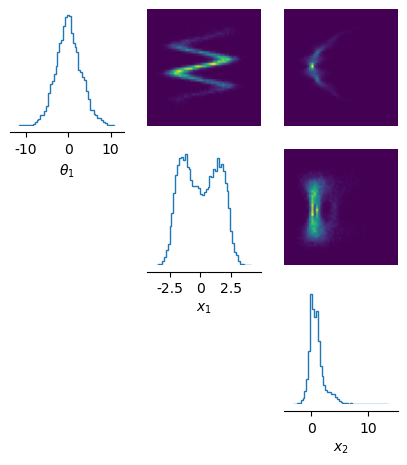

In [23]:
# with use_style("pyloric"):
fig,axes = pairplot(np.array(samples), figsize=(5,5), labels=["$\\theta_1$", "$x_1$", "$x_2$"], diag_kind="kde", color="black", linewidth=2)

In [24]:
condition_mask1 = jnp.zeros((1,)) # we are not performing any conditioning, but we still need to pass a mask

x_init = jax.random.normal(jax.random.PRNGKey(0), (20_000, 1))  # initial conditions

args1 = {"node_ids": jnp.array([0,])}
sampler_ = solver.get_sampler(time_grid=T, condition_mask=condition_mask1, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=args1)
marginal_samples1 = sampler_(x_init)  # sample from the model

args2 = {"node_ids": jnp.array([1,])}
sampler_ = solver.get_sampler(time_grid=T, condition_mask=condition_mask1, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=args2)
marginal_samples2 = sampler_(x_init)  # sample from the model

args3 = {"node_ids": jnp.array([2,])}
sampler_ = solver.get_sampler(time_grid=T, condition_mask=condition_mask1, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=args3)
marginal_samples3 = sampler_(x_init)  # sample from the model


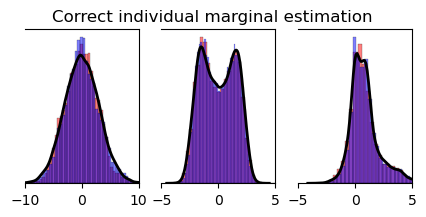

In [25]:
# with use_style("pyloric"):
fig, ax = plt.subplots(1,3, figsize=(5,2))
sns.histplot(marginal_samples1[:,0], bins=50, ax=ax[0], stat="density", color="red", alpha=0.5)
sns.histplot(marginal_samples2[:,0], bins=50, ax=ax[1], stat="density", color="red", alpha=0.5)
sns.histplot(marginal_samples3[:,0], bins=50, ax=ax[2], stat="density", color="red", alpha=0.5)

sns.histplot(samples[:, 0], bins=50, ax=ax[0], stat="density", color="blue", alpha=0.5)
sns.histplot(samples[:, 1], bins=50, ax=ax[1], stat="density", color="blue", alpha=0.5)
sns.histplot(samples[:, 2], bins=50, ax=ax[2], stat="density", color="blue", alpha=0.5)
sns.kdeplot(data[:, 0], ax=ax[0], color="black", linewidth=2)
sns.kdeplot(data[:, 1], ax=ax[1], color="black", linewidth=2)
sns.kdeplot(data[:, 2], ax=ax[2], color="black", linewidth=2)

ax[0].set_xlim(-10,10)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)
fig.suptitle("Correct individual marginal estimation")
for ax in ax:
    ax.yaxis.set_visible(False)
    # remove y spines
    ax.spines['left'].set_visible(False)
    

        


## compute the marginal posterior analytically

In [26]:
import numpyro.distributions as dist

In [27]:
solver = ODESolver(velocity_model=vf_model)

In [28]:
# source distribution is an isotropic gaussian
gaussian_log_density = dist.Independent(dist.Normal(jnp.zeros(1), jnp.ones(1)),1).log_prob

In [29]:
x_1 = jnp.linspace(-10,10,200).reshape(-1,1)
x_2 = jnp.linspace(-5,5,200).reshape(-1,1)
x_3 = jnp.linspace(-5,5,200).reshape(-1,1)

In [30]:
condition_mask1 = jnp.zeros((1,)) # we are not performing any conditioning, but we still need to pass a mask
args1 = {"node_ids": jnp.array([0,])}

logp1 = solver.get_unnormalized_logprob(condition_mask=condition_mask1, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=gaussian_log_density, model_extras=args1)
_, exact_log_p1 = logp1(x_1)

p1 = jnp.exp(exact_log_p1)
p1.shape

(1, 200)

In [31]:
condition_mask1 = jnp.zeros((1,)) # we are not performing any conditioning, but we still need to pass a mask
args1 = {"node_ids": jnp.array([0,])}

logp1 = solver.get_unnormalized_logprob(condition_mask=condition_mask1, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=gaussian_log_density, model_extras=args1)
_, exact_log_p1 = logp1(x_1)

p1 = jnp.exp(exact_log_p1)[-1]
# normalize the distribution
n1 = jax.scipy.integrate.trapezoid(p1, x_1.flatten())
p1 = p1/n1

condition_mask2 = jnp.zeros((1,)) # we are not performing any conditioning, but we still need to pass a mask
args2 = {"node_ids": jnp.array([1,])}
logp2 = solver.get_unnormalized_logprob(condition_mask=condition_mask2, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=gaussian_log_density, model_extras=args2)
_, exact_log_p2 = logp2(x_2)
p2 = jnp.exp(exact_log_p2)[-1]
# normalize the distribution
n2 = jax.scipy.integrate.trapezoid(p2, x_2.flatten())
p2 = p2/n2


condition_mask3 = jnp.zeros((1,)) # we are not performing any conditioning, but we still need to pass a mask
args3 = {"node_ids": jnp.array([2,])}
logp3 = solver.get_unnormalized_logprob(condition_mask=condition_mask3, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=gaussian_log_density, model_extras=args3)
_, exact_log_p3 = logp3(x_3)
p3 = jnp.exp(exact_log_p3)[-1]
# normalize the distribution
n3 = jax.scipy.integrate.trapezoid(p3, x_3.flatten())
p3 = p3/n3


In [32]:
data_plot = generate_data(jrandom.PRNGKey(1), 100_000)

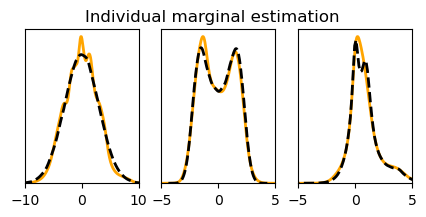

In [33]:
fig, ax = plt.subplots(1,3, figsize=(5,2))

ax[0].plot(x_1, p1, color="orange", linewidth=2)
ax[1].plot(x_2, p2, color="orange", linewidth=2)
ax[2].plot(x_3, p3, color="orange", linewidth=2)

sns.kdeplot(data_plot[:, 0], ax=ax[0], color="black", linewidth=2, ls="--")
sns.kdeplot(data_plot[:, 1], ax=ax[1], color="black", linewidth=2, ls="--")
sns.kdeplot(data_plot[:, 2], ax=ax[2], color="black", linewidth=2, ls="--")

ax[0].set_xlim(-10,10)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)
fig.suptitle("Individual marginal estimation")
for ax in ax:
    ax.yaxis.set_visible(False)
    # remove y spines
    # ax.spines['left'].set_visible(False)
    

### 7) Arbitrary conditional distributions

In [34]:
def true_posterior(theta, x1=None, x2=None):
    potential_theta = partial(log_potential, x1=x1, x2=x2)
    potential_post = potential_theta(theta)
    potential_post = potential_post - potential_post.max()
    potential_post = jnp.exp(potential_post)
    potential_post = potential_post / jnp.trapezoid(potential_post, x=theta)
    return potential_post

In [35]:
solver = ODESolver(velocity_model=vf_model)

In [46]:
# Full conditional estimation
theta = jnp.linspace(-10, 10, 1000)
theta2 = jnp.linspace(-5, 5, 1000)
x_o = data[6,:]
true_post = true_posterior(theta, x_o[1], x_o[2])

condition_mask = jnp.array([0,1,1], dtype=jnp.bool_)
x_init = jax.random.normal(jax.random.PRNGKey(0), (20_000, 3))  # initial conditions
x_init = jnp.where(condition_mask, x_o[None,:], x_init)  # we replace the conditioned values in the initial conditions

args = {"node_ids": jnp.array([0,1,2])}
sampler_ = solver.get_sampler(condition_mask=condition_mask, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=args)
samples = sampler_(x_init)  # sample from the model



In [47]:
gaussian_log_density = dist.Independent(dist.Normal(jnp.zeros(3), jnp.ones(3)),1).log_prob

# get the logprob
logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=gaussian_log_density, model_extras=args)
# create an y_init which has theta on the first position and x1,x2 on the second and third position
y_init = jnp.zeros((theta.shape[0], 3))
y_init = y_init.at[:,0].set(theta)
y_init = y_init.at[:,1].set(x_o[1])
y_init = y_init.at[:,2].set(x_o[2])

_ , exact_log_p = logp_sampler(y_init)
p = jnp.exp(exact_log_p)[-1]
# # normalize the distribution
n = jax.scipy.integrate.trapezoid(p, theta)
p = p/n



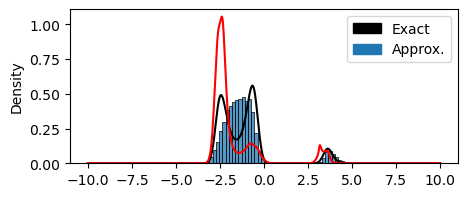

In [48]:
samples_theta = samples[:, 0]

fig = plt.figure(figsize=(5, 2))
sns.histplot(samples_theta, bins=50, stat="density")
plt.plot(theta, true_post, color="black", label="True posterior")
plt.plot(theta, p, color="red", label="Approx. posterior")
exact_patch = mpatches.Patch(color='black', label='Exact')
approx_patch = mpatches.Patch(color='C0', label='Approx.')
plt.legend(handles=[exact_patch, approx_patch])
plt.show()

In [62]:
# Partial conditional estimation
theta = jnp.linspace(-10, 10, 1000)
x_o = data[4,:]
true_post = true_posterior(theta, x_o[1], None)

condition_mask = jnp.array([0,1,0], dtype=jnp.bool_)
x_init = jax.random.normal(jax.random.PRNGKey(0), (20_000, 3))  # initial conditions
x_init = jnp.where(condition_mask, x_o[None,:], x_init)  # we replace the conditioned values in the initial conditions


args = {"node_ids": jnp.array([0,1,2])}
sampler_ = solver.get_sampler(condition_mask=condition_mask, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=args)
samples = sampler_(x_init)  # sample from the model

In [68]:
y_init = jnp.sort(samples, axis=0)

In [64]:
y_init.shape

(4000, 3)

In [69]:
gaussian_log_density = dist.Independent(dist.Normal(jnp.zeros(3), jnp.ones(3)),1).log_prob

# get the logprob
logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=gaussian_log_density, model_extras=args)
# create an y_init which has theta on the first position and x1,x2 on the second and third position
# y_init = jax.random.normal(rng, shape=(theta.shape[0], 3))
# y_init = y_init.at[:,0].set(theta)
# y_init = y_init.at[:,1].set(x_o[1])
# y_init = y_init.at[:,2].set(theta2)
# # y_init = y_init.at[:,2].set(x_o[2])

theta_i = y_init[:,0]

_ , exact_log_p = logp_sampler(y_init)
p = jnp.exp(exact_log_p)[-1,:]
# # normalize the distribution
n = jax.scipy.integrate.trapezoid(p, theta_i)
p = p/n

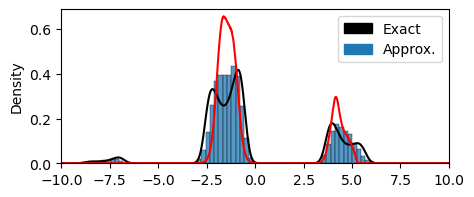

In [70]:

import matplotlib.patches as mpatches
samples_theta = samples[:, 0]
fig = plt.figure(figsize=(5, 2))
sns.histplot(samples_theta, bins=100, stat="density")
plt.plot(theta, true_post, color="black", label="True posterior")
plt.plot(theta_i, p, color="red", label="Approx. posterior")
exact_patch = mpatches.Patch(color='black', label='Exact')
approx_patch = mpatches.Patch(color='C0', label='Approx.')
plt.legend(handles=[exact_patch, approx_patch])
plt.xlim(-10, 10)
plt.show()


### 8) Arbitrary constraints

Here a simplified version constraint conditioning

In [32]:
# Simplified sampling with guidance...

def s(t):
    # Some scaling function
    t = jnp.atleast_1d(t)
    return jnp.exp(-t**2*5)*100

def log_step_fun(t,x,a,b):
    # Step_fn constraint -> Intervals
    scale = s(t)
    x1 = jax.nn.log_sigmoid(jnp.sum(scale * (x - a), axis=-1))
    x2 = jax.nn.log_sigmoid(jnp.sum(-scale * (x - b), axis=-1))

    return x1 + x2

def log_linear_fn_approximation(t,x, a):
    # Linear constrait <s,a> = 0.
    scale = s(t)
    a = a.reshape(-1,x.shape[1],1)
    x1 = jax.nn.log_sigmoid(scale *jnp.sum((x * a), axis=1))
    x2 = jax.nn.log_sigmoid(-scale *jnp.sum((x * a), axis=1))
    return x1 + x2

def log_polytope_fn_approximation(t,x, A):
    # Polytope constraint 
    scale = s(t)
    a = x.reshape(-1, x.shape[1])
    constraint = jax.nn.relu(scale * (jnp.matmul(a, A.T) - 1.)).max(axis=-1)
    constraint = jax.nn.log_sigmoid(-constraint) 
    return constraint



step_fn_score = jax.grad(lambda *args: log_step_fun(*args).sum(), argnums=1)
linear_fn_score = jax.grad(lambda *args: log_linear_fn_approximation(*args).sum(), argnums=1)
polytope_fn_score = jax.grad(lambda *args: log_polytope_fn_approximation(*args).sum(), argnums=1)
    

In [33]:
# Wappers around score functions to include the constraints

def interval_score(x,t, node_ids, condition_mask, edge_mask, a,b):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids))
    score = score_model(x, t, node_ids, jnp.zeros_like(condition_mask), edge_mask)
    tweedies_x0_estimator = (x + ve.marginal_stddev(jnp.array([1.]), t)**2 * score)/ve.marginal_mean(jnp.array([1.]), t) # Predict x0
    interval_score_est = step_fn_score(t,tweedies_x0_estimator,a,b) * condition_mask#.reshape(-1, len(node_ids))
    return score + interval_score_est

def linear_score(x,t, node_ids, condition_mask, edge_mask, a):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids))
    score = score_model(x, t, node_ids, jnp.zeros_like(condition_mask), edge_mask)
    tweedies_x0_estimator = (x + ve.marginal_stddev(jnp.array([1.]), t)**2 * score)/ve.marginal_mean(jnp.array([1.]), t) # Predict x0
    linear_score_est = linear_fn_score(t,tweedies_x0_estimator,a) * condition_mask#.reshape(-1, len(node_ids))
    return score + linear_score_est

def polytope_score(x,t,  node_ids, condition_mask, edge_mask, A):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids))
    score = score_model(x, t, node_ids, jnp.zeros_like(condition_mask), edge_mask)
    tweedies_x0_estimator = (x + ve.marginal_stddev(jnp.array([1.]), t)**2 * score)/ve.marginal_mean(jnp.array([1.]), t) # Predict x0
    polytope_score_est = polytope_fn_score(t,tweedies_x0_estimator,A) #* condition_mask.reshape(-1, len(node_ids), 1)
    return score + polytope_score_est

score_fn1 = partial(interval_score,  a=2.*jnp.ones(1), b=jnp.ones(1)*3)
score_fn3 = partial(linear_score, a=jnp.array([1., 5.]))
score_fn4 = partial(polytope_score, A=0.3*jax.random.normal(jrandom.PRNGKey(0), (8,2)))

In [34]:
ve_ = sde_ours.VESDE(2, sigma_min=1e-3, sigma_max=15.)

rev1 = ve_.reverse(score_fn1)
condition_mask = jnp.array([0,1], dtype=int)
condition_value = jnp.zeros((1,2,))
score_args = {"node_ids": jnp.array([0,1]), "condition_mask": condition_mask, "edge_mask":None}
samples1 = rev1.sample(rng, 1000, condition_mask=condition_mask, condition_value=condition_value, score_args=score_args, replace_conditioned=False)

# samples1 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), score_fn=score_fn1, replace_conditioned=False)

In [35]:
rev2 = ve_.reverse(score_fn3)
condition_mask = jnp.array([1,1], dtype=int)
condition_value = jnp.zeros((1,2,))
score_args = {"node_ids": jnp.array([0,1]), "condition_mask": condition_mask, "edge_mask":None}
samples2 = rev2.sample(rng, 1000, condition_mask=condition_mask, condition_value=condition_value, score_args=score_args, replace_conditioned=False)

# samples2 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([1,1], dtype=int), score_fn=score_fn3, replace_conditioned=False)

In [36]:
rev3 = ve_.reverse(score_fn4)
condition_mask = jnp.array([1,1], dtype=int)
condition_value = jnp.zeros((1,2,))
score_args = {"node_ids": jnp.array([0,1]), "condition_mask": condition_mask, "edge_mask":None}
samples3 = rev3.sample(rng, 1000, condition_mask=condition_mask, condition_value=condition_value, score_args=score_args, replace_conditioned=False)

# samples3 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([1,1], dtype=int), score_fn=score_fn4, replace_conditioned=False)

In [37]:
# Auxiliarly for plotting

def pot(x):
    return jnp.exp(log_polytope_fn_approximation(0.001, x, 0.3*jax.random.normal(jrandom.PRNGKey(0), (8,2))))


potential_fn = jax.vmap(jax.scipy.stats.gaussian_kde(data[:,[0,1]].T, bw_method="silverman"))
x = jnp.linspace(data[:, 0].min(), data[:, 0].max(), 200)
y = jnp.linspace(data[:, 1].min(), data[:, 1].max(), 200)
X, Y = jnp.meshgrid(x, y)
pos = jnp.dstack((X, Y))
Z_true = potential_fn(pos.reshape(-1,2)).reshape(200,200)
Z = pot(pos.reshape(-1,2)).reshape(200,200)


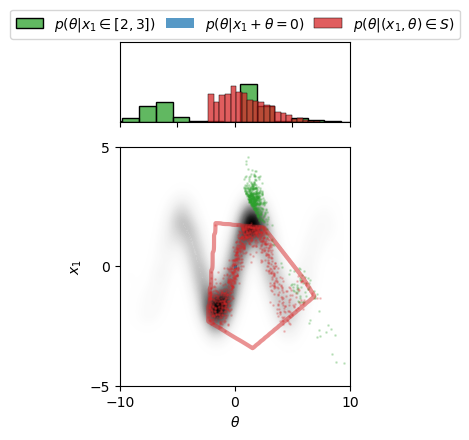

In [ ]:
# from scoresbibm.plot import use_style
# with use_style("pyloric"):

fig, axs = plt.subplots(2, 1, figsize=(4., 4.5), gridspec_kw={'height_ratios': [1, 3]})

# 2D scatter plot
l = axs[1].contour(X, Y, Z,colors="tab:red", levels=[0.4], alpha=0.5, linewidths=3)
axs[1].contourf(X, Y, Z_true, cmap="Greys", levels=200, vmin=0, alpha=0.9)
axs[1].scatter(samples1[:, 0], samples1[:, 1], s=1, alpha=0.2, color="tab:green")
axs[1].scatter(samples2[:, 0], samples2[:, 1], s=1, alpha=0.05, color="tab:blue")
axs[1].scatter(samples3[:, 0], samples3[:, 1], s=1, alpha=0.2, color="tab:red")
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-5, 5)
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$x_1$")

# 1D marginal plot
_ = sns.histplot(samples1[:, 0], ax=axs[0], bins=20, color="tab:green", stat="density")
_ = sns.histplot(samples2[:, 0], ax=axs[0], bins=20,color="tab:blue", stat="density")
_ = sns.histplot(samples3[:, 0], ax=axs[0],bins=20, color="tab:red", stat="density")
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(0, 0.5)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_ylabel("")
axs[0].yaxis.set_visible(False)
axs[1].set_xticks([-10,0,10])
axs[1].set_yticks([-5,0,5])

axs[0].legend([r"$p(\theta|x_1 \in [2,3])$", r"$p(\theta|x_1 + \theta = 0)$", r"$p(\theta|(x_1,\theta)\in S)$"], ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.5),columnspacing=0.7)
plt.tight_layout()
plt.show() # wrong

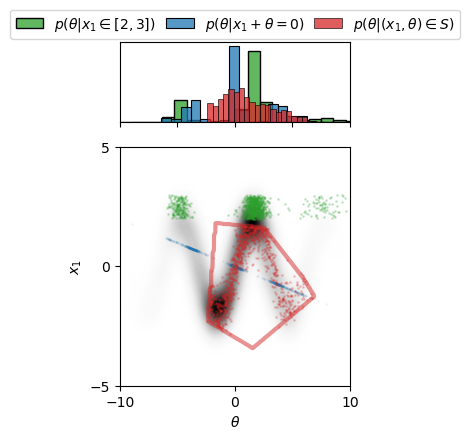

### 9) Change priors or likelihoods


$$ p(\theta) \propto \exp\left(-\frac{(\theta - \mu)^2}{2\sigma^2}\right) $$
$$ \nabla_\theta \log p(\theta) = \frac{\theta - \mu}{\sigma^2} $$

In training we have $\sigma^2 = 9$.
Now for any $\alpha$ we have
$$ p(\theta)^\alpha = \exp\left(-\frac{\alpha(\theta - \mu)^2}{2\sigma^2}\right) = \exp\left(-\frac{(\theta - \mu)^2}{2\sigma^2/\alpha}\right) $$

So if we want a certain variance $\sigma_0^2$. All we have to do is to multiply the score by $\alpha = \sigma^2/\sigma_0^2$.

If we want to change the mean then we have to add $\mu_0 - \mu / \sigma^2$ to the score.

In [39]:
raise NotImplementedError("The following code is not working yet")

NotImplementedError: The following code is not working yet

In [88]:
# Score function wrappers with manipulations
def score_prior_change(params, t, x, node_ids, condition_mask, edge_mask, node_ids_to_change, scale=1., shift=0.):

    index = jnp.searchsorted(node_ids,node_ids_to_change)    
    score_unconditioned = model_fn(params, t, x[:,index], node_ids=node_ids_to_change, condition_mask=jnp.zeros_like(node_ids_to_change))

    score_conditional = model_fn(params, t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=edge_mask)
    score_conditional = score_conditional.at[:,index].set(scale * (score_unconditioned - shift) + (score_conditional[:,index] - score_unconditioned))
    
    return score_conditional

def score_likelihood_change(params, t, x, node_ids, condition_mask, edge_mask, node_ids_to_change, scale=1., shift=0.):

    index = jnp.searchsorted(node_ids,node_ids_to_change)    
    score_unconditioned = model_fn(params, t, x[:,index], node_ids=node_ids_to_change, condition_mask=jnp.zeros_like(node_ids_to_change))

    score_conditional = model_fn(params, t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=edge_mask)
    score_conditional =  score_conditional.at[:,index].set(score_unconditioned + (scale*(score_conditional[:,index] - score_unconditioned)) - shift)
    
    return score_conditional


In [ ]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, mean_scale=jnp.sqrt(12.))
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


In [ ]:
# Change to N(0, 2) prior -> shift = 9/4
score_fn_prior_change = partial(score_prior_change, scale=9/12., shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (5000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_prior_change)
with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=100, stat="density", label= "Approx.")
    plt.plot(x, jax.scipy.stats.norm.pdf(x, 0, 2), color="black", linestyle="--", label="Prior")
    plt.plot(x, potential_post, color="black", label="Exact")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\theta$")
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    ax.set_xlim(-10,10)


In [ ]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, mean_scale=1, mean_loc=2)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


In [ ]:
# Change to N(2, 1) prior -> shift = 9/2, loc = 2/9
score_fn_prior_change = partial(score_prior_change, scale=9/2, shift=-2/9, node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_prior_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=50, stat="density", label= "Approx.")
    plt.plot(x, jax.scipy.stats.norm.pdf(x, 2., np.sqrt(2.)), color="black", linestyle="--", label="Prior")
    plt.plot(x, potential_post, color="black", label="Exact")
    plt.legend()
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")

In [ ]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, sigma_x1=jnp.sqrt(0.05))
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


In [ ]:
# Likelihood very certain
score_fn_likelihood_change = partial(score_likelihood_change, scale=0.5**2/0.05, shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_likelihood_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=200, stat="density")
    plt.plot(x, potential_post, color="black")
    plt.legend(["exact", "approx."], loc="upper left")
    plt.xlim(-10,10)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")

In [ ]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, sigma_x1=2.)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


In [ ]:
# Likelihood very certain
score_fn_likelihood_change = partial(score_likelihood_change, scale=0.5**2/4., shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (10000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_likelihood_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=100, stat="density")
    plt.plot(x, potential_post, color="black")
    plt.legend(["exact", "approx."], loc="upper left")
    plt.xlim(-10,10)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")